In [1]:
import polars as pl
from sentence_transformers import SentenceTransformer, util

In [2]:
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
df = pl.read_csv("./csv_data//deoksan.csv")
col_lis = list(df.schema.keys())

In [5]:
import polars as pl
import pandas as pd
import os
import re
from sentence_transformers import SentenceTransformer, util
from rdflib import Graph, Literal, RDF, Namespace, XSD
import urllib.parse
from typing import Dict, List, Tuple, Optional
from dataclasses import dataclass

# ============================================
# 1. 규칙 기반 매핑 (Rule-based Mapping)
# ============================================
class RuleBasedMapper:
    """고신뢰도 키워드 기반 규칙 매핑"""
    
    def __init__(self):
        # 도메인별 키워드 사전 (실무에서 도메인 지식 반영)
        self.keyword_rules = {
            "Injection_Molding_Machine": [
                "injection", "molding", "moulding", "plastic", "inj", "사출"
            ],
            "Welding_Robot": [
                "welding", "welder", "weld", "robot", "용접"
            ],
            "Industrial_Pump": [
                "pump", "펌프", "pressure"
            ],
            "CNC_Machine": [
                "cnc", "machining", "nc", "가공"
            ],
            "Conveyor_Belt": [
                "conveyor", "belt", "컨베이어", "transport"
            ],
            "Motor": [
                "motor", "curr", "current", "voltage", "volt", "모터"
            ]
        }
        
        # 컬럼명 패턴 기반 추론 규칙
        self.column_patterns = {
            "Motor": ["curr", "voltage", "volt", "rpm", "torque"],
            "Temperature": ["temp", "temperature", "pt100", "thermo"],
            "Vibration": ["vib", "vibration", "accel", "frequency"],
            "Pressure": ["pressure", "press", "psi", "bar"]
        }
    
    def preprocess_text(self, text: str) -> str:
        """텍스트 전처리 (규칙 매칭용)"""
        text = text.lower()
        text = re.sub(r'[^a-z0-9\s]', ' ', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text
    
    def match_by_keywords(self, filename: str) -> Optional[Tuple[str, float]]:
        """키워드 기반 매칭 (고신뢰도)"""
        clean_name = self.preprocess_filename(filename)
        words = clean_name.split()
        
        best_match = None
        best_score = 0.0
        
        for class_name, keywords in self.keyword_rules.items():
            matches = sum(1 for kw in keywords if kw in clean_name or any(kw in word for word in words))
            if matches > 0:
                # 매칭된 키워드 수에 비례한 점수
                score = min(0.95, 0.7 + (matches * 0.1))
                if score > best_score:
                    best_score = score
                    best_match = class_name
        
        return (best_match, best_score) if best_match else None
    
    def preprocess_filename(self, fname: str) -> str:
        """파일명 전처리"""
        name = fname.replace('.csv', '').replace('.CSV', '')
        name = re.sub(r'[_\-\d]', ' ', name)
        return name.lower().strip()
    
    def infer_from_columns(self, columns: List[str]) -> Optional[Tuple[str, float]]:
        """컬럼명으로부터 기계 타입 추론"""
        col_str = ' '.join([c.lower() for c in columns])
        
        best_match = None
        best_score = 0.0
        
        for machine_type, patterns in self.column_patterns.items():
            matches = sum(1 for pattern in patterns if pattern in col_str)
            if matches > 0:
                score = min(0.85, 0.5 + (matches * 0.15))
                if score > best_score:
                    best_score = score
                    best_match = machine_type
        
        return (best_match, best_score) if best_match else None


# ============================================
# 2. 시맨틱 매핑 (Semantic Matching)
# ============================================

class SemanticMapper:
    """임베딩 기반 시맨틱 매핑"""
    
    def __init__(self, model_name: str = 'sentence-transformers/all-MiniLM-L6-v2'):
        self.model = SentenceTransformer(model_name)
    
    def preprocess_filename(self, fname: str) -> str:
        """파일명 전처리 (시맨틱 매칭용)"""
        name = fname.replace('.csv', '').replace('_', ' ').replace('-', ' ')
        return name.strip()
    
    def map_semantic(self, files: List[str], classes: List[str]) -> pd.DataFrame:
        """시맨틱 매핑 수행"""
        clean_names = [self.preprocess_filename(f) for f in files]
        embeddings_files = self.model.encode(clean_names)
        embeddings_classes = self.model.encode(classes)
        
        scores = util.cos_sim(embeddings_files, embeddings_classes)
        
        results = []
        for i, fname in enumerate(files):
            best_idx = scores[i].argmax().item()
            best_score = scores[i][best_idx].item()
            best_class = classes[best_idx]
            
            results.append({
                "Filename": fname,
                "Interpreted_As": clean_names[i],
                "Mapped_Class": best_class,
                "Confidence": round(best_score, 3)
            })
        
        return pd.DataFrame(results)


# ============================================
# 3. 하이브리드 매핑 (Hybrid Approach) - 핵심
# ============================================

@dataclass
class MappingResult:
    """매핑 결과 데이터 클래스"""
    filename: str
    mapped_class: str
    confidence: float
    method: str  # "rule", "semantic", "column_inference", "unclassified"
    interpreted_as: str
    column_hint: Optional[str] = None

class HybridMapper:
    """하이브리드 매핑: 규칙 + 시맨틱 + 컬럼 추론"""
    
    def __init__(self, ontology_classes: List[str], model_name: str = 'sentence-transformers/all-MiniLM-L6-v2'):
        self.rule_mapper = RuleBasedMapper()
        self.semantic_mapper = SemanticMapper(model_name)
        self.ontology_classes = ontology_classes
        
        # 신뢰도 임계값 설정
        self.HIGH_CONFIDENCE = 0.7
        self.MEDIUM_CONFIDENCE = 0.4
        self.LOW_CONFIDENCE = 0.0
    
    def map_file(self, filename: str, columns: Optional[List[str]] = None) -> MappingResult:
        """
        단일 파일 매핑 (하이브리드 로직)
        
        우선순위:
        1. 규칙 기반 매칭 (고신뢰도)
        2. 컬럼명 추론 (파일명 불명확 시)
        3. 시맨틱 매칭
        4. Unclassified
        """
        # Step 1: 규칙 기반 매칭 시도
        rule_result = self.rule_mapper.match_by_keywords(filename)
        if rule_result and rule_result[1] >= self.HIGH_CONFIDENCE:
            return MappingResult(
                filename=filename,
                mapped_class=rule_result[0],
                confidence=rule_result[1],
                method="rule",
                interpreted_as=self.rule_mapper.preprocess_filename(filename)
            )
        
        # Step 2: 컬럼명 기반 추론 (파일명이 불명확할 때)
        if columns:
            col_result = self.rule_mapper.infer_from_columns(columns)
            if col_result and col_result[1] >= self.MEDIUM_CONFIDENCE:
                return MappingResult(
                    filename=filename,
                    mapped_class=col_result[0],
                    confidence=col_result[1],
                    method="column_inference",
                    interpreted_as=self.rule_mapper.preprocess_filename(filename),
                    column_hint=f"Detected from columns: {', '.join(columns[:3])}"
                )
        
        # Step 3: 시맨틱 매칭
        semantic_df = self.semantic_mapper.map_semantic([filename], self.ontology_classes)
        semantic_score = semantic_df.iloc[0]['Confidence']
        semantic_class = semantic_df.iloc[0]['Mapped_Class']
        
        if semantic_score >= self.MEDIUM_CONFIDENCE:
            return MappingResult(
                filename=filename,
                mapped_class=semantic_class,
                confidence=semantic_score,
                method="semantic",
                interpreted_as=semantic_df.iloc[0]['Interpreted_As']
            )
        
        # Step 4: 모든 방법 실패 시 Unclassified
        return MappingResult(
            filename=filename,
            mapped_class="Unclassified",
            confidence=0.0,
            method="unclassified",
            interpreted_as=self.rule_mapper.preprocess_filename(filename)
        )
    
    def map_files(self, filenames: List[str], file_columns: Optional[Dict[str, List[str]]] = None) -> pd.DataFrame:
        """
        여러 파일 일괄 매핑
        
        Args:
            filenames: 파일명 리스트
            file_columns: {filename: [column_names]} 딕셔너리 (선택)
        """
        results = []
        
        for filename in filenames:
            columns = file_columns.get(filename) if file_columns else None
            result = self.map_file(filename, columns)
            
            results.append({
                "Filename": result.filename,
                "Interpreted_As": result.interpreted_as,
                "Mapped_Class": result.mapped_class,
                "Confidence": round(result.confidence, 3),
                "Method": result.method,
                "Column_Hint": result.column_hint or "-"
            })
        
        return pd.DataFrame(results)


# ============================================
# 4. 개선된 온톨로지 구축 함수
# ============================================

def build_hybrid_ontology(
    input_folder: str,
    ontology_classes: List[str],
    output_file: str = "metadata_ontology.ttl",
    model_name: str = 'sentence-transformers/all-MiniLM-L6-v2'
):
    """
    하이브리드 접근법으로 온톨로지 구축
    
    Args:
        input_folder: CSV 파일이 있는 폴더
        ontology_classes: 표준 온톨로지 클래스 리스트
        output_file: 출력 TTL 파일명
        model_name: SentenceTransformer 모델명
    """
    print("🧐 하이브리드 온톨로지 구축을 시작합니다...")
    
    # 네임스페이스 설정
    BASE_URI = "http://factory.org/meta/"
    META = Namespace(BASE_URI)
    FACT = Namespace("http://factory.org/")
    g = Graph()
    g.bind("meta", META)
    g.bind("fact", FACT)
    
    # 하이브리드 매퍼 초기화
    mapper = HybridMapper(ontology_classes, model_name)
    
    # 폴더 내 파일 탐색
    if not os.path.exists(input_folder):
        os.makedirs(input_folder)
        print(f"   [안내] '{input_folder}' 폴더가 생성되었습니다.")
        # 빈 DataFrame과 Graph 반환
        return pd.DataFrame(), g
    
    files = [f for f in os.listdir(input_folder) if f.endswith((".csv", ".CSV"))]
    
    if not files:
        print(f"   [경고] '{input_folder}' 폴더에 CSV 파일이 없습니다.")
        # 빈 DataFrame과 Graph 반환
        return pd.DataFrame(), g
    
    # 파일별 컬럼 정보 수집 (스키마만 스캔)
    file_columns = {}
    for filename in files:
        file_path = os.path.join(input_folder, filename)
        try:
            lf = pl.scan_csv(file_path)
            schema = lf.collect_schema()
            file_columns[filename] = list(schema.keys())
        except Exception as e:
            print(f"   [주의] 파일을 읽을 수 없습니다: {filename} ({e})")
            file_columns[filename] = []
    
    # 하이브리드 매핑 수행
    mapping_df = mapper.map_files(files, file_columns)
    
    print("\n📊 매핑 결과:")
    print(mapping_df.to_string(index=False))
    
    # 온톨로지 구축
    for _, row in mapping_df.iterrows():
        filename = row['Filename']
        mapped_class = row['Mapped_Class']
        confidence = row['Confidence']
        method = row['Method']
        
        if mapped_class == "Unclassified":
            print(f"   ⚠️  {filename}: 매핑 실패 (수동 검토 필요)")
            continue
        
        # 파일 경로
        file_path = os.path.join(input_folder, filename)
        dataset_name = os.path.splitext(filename)[0]
        dataset_uri = FACT[urllib.parse.quote(dataset_name)]
        class_uri = FACT[urllib.parse.quote(mapped_class)]
        
        # 데이터셋 객체 생성
        g.add((dataset_uri, RDF.type, META.Dataset))
        g.add((dataset_uri, META.hasFileName, Literal(filename)))
        g.add((dataset_uri, META.hasFilePath, Literal(os.path.abspath(file_path))))
        
        # 클래스 매핑
        g.add((dataset_uri, FACT.isDataOf, class_uri))
        g.add((dataset_uri, META.mappingConfidence, Literal(float(confidence), datatype=XSD.float)))
        g.add((dataset_uri, META.mappingMethod, Literal(method)))
        
        # 컬럼 정보 추가
        if filename in file_columns:
            for col_name in file_columns[filename]:
                col_id = f"{dataset_name}_{col_name}"
                col_uri = META[urllib.parse.quote(col_id)]
                
                g.add((col_uri, RDF.type, META.DataColumn))
                g.add((dataset_uri, META.hasColumn, col_uri))
                g.add((col_uri, META.columnName, Literal(col_name)))
        
        print(f"   ✅ {filename} → {mapped_class} ({method}, confidence: {confidence:.2f})")
    
    # 결과 저장
    if len(mapping_df) > 0:  # 파일이 있을 때만 저장
        g.serialize(destination=output_file, format="turtle")
        print(f"\n✅ 온톨로지 구축 완료! ({output_file})")
        
        # 통계 출력
        method_counts = mapping_df['Method'].value_counts()
        print("\n📈 매핑 방법 통계:")
        for method, count in method_counts.items():
            print(f"   {method}: {count}개")
    
    return mapping_df, g

In [6]:
if __name__ == "__main__":
    # 온톨로지 클래스 정의
    ontology_classes = [
        "Injection_Molding_Machine",
        "Welding_Robot",
        "Industrial_Pump",
        "CNC_Machine",
        "Conveyor_Belt",
        "Motor"
    ]
    
    # 온톨로지 구축 실행
    mapping_df, graph = build_hybrid_ontology(
        input_folder="./csv_data",
        ontology_classes=ontology_classes,
        output_file="metadata_ontology_hybrid.ttl"
    )
    
    # 결과 확인
    print("\n" + "="*50)
    print("매핑 결과 상세:")
    print("="*50)
    print(mapping_df)

🧐 하이브리드 온톨로지 구축을 시작합니다...

📊 매핑 결과:
   Filename Interpreted_As Mapped_Class  Confidence           Method                              Column_Hint
deoksan.csv        deoksan        Motor         0.8 column_inference Detected from columns: time, curr, currR
   ✅ deoksan.csv → Motor (column_inference, confidence: 0.80)

✅ 온톨로지 구축 완료! (metadata_ontology_hybrid.ttl)

📈 매핑 방법 통계:
   column_inference: 1개

매핑 결과 상세:
      Filename Interpreted_As Mapped_Class  Confidence            Method  \
0  deoksan.csv        deoksan        Motor         0.8  column_inference   

                                Column_Hint  
0  Detected from columns: time, curr, currR  


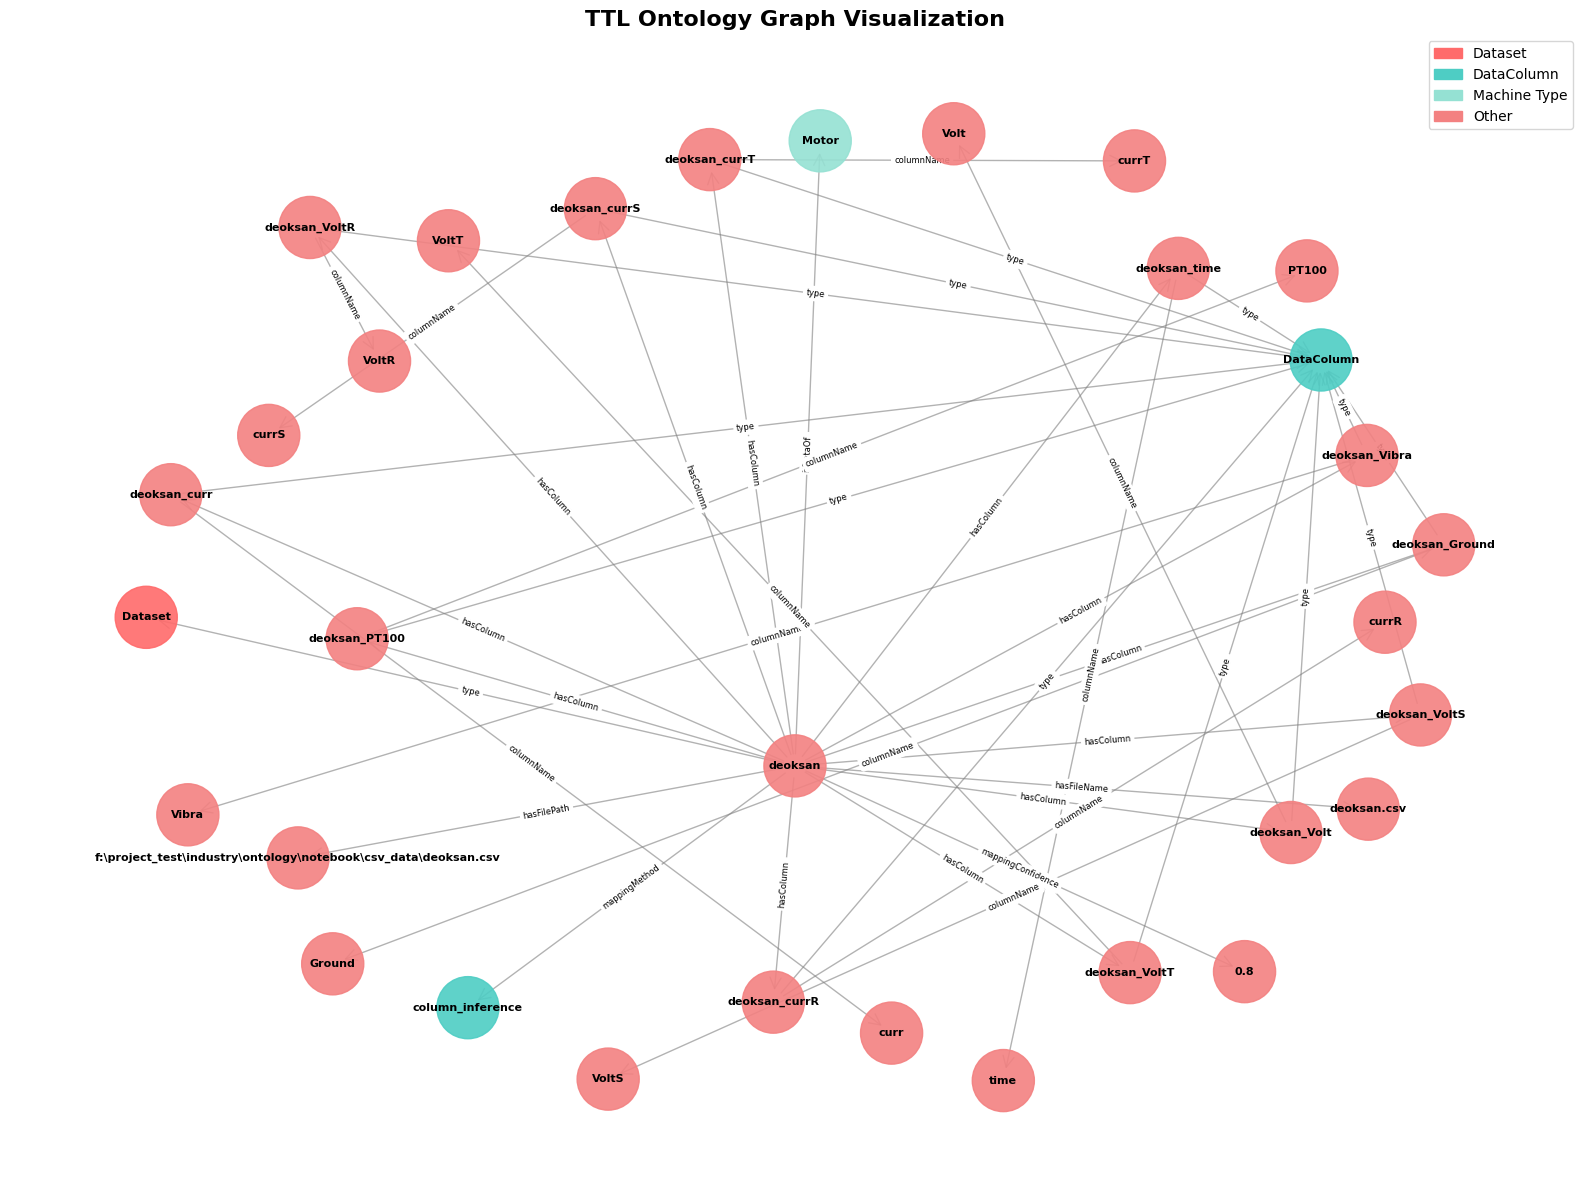

✅ 그래프 저장 완료: ontology_visualization.png
   노드 수: 32
   엣지 수: 42


In [8]:
import networkx as nx
import matplotlib.pyplot as plt
from rdflib import Graph, Namespace
import matplotlib.patches as mpatches

def visualize_ttl_networkx(ttl_file: str, output_file: str = "ontology_graph.png"):
    """
    NetworkX를 사용한 TTL 그래프 시각화
    """
    # TTL 파일 로드
    g = Graph()
    g.parse(ttl_file, format="turtle")
    
    # NetworkX 그래프 생성
    G = nx.DiGraph()
    
    # 노드와 엣지 추가
    node_colors = {}
    node_labels = {}
    
    for s, p, o in g:
        # 주제(subject) 노드
        s_str = str(s).split('/')[-1].split('#')[-1]
        G.add_node(s_str)
        node_labels[s_str] = s_str
        
        # 객체(object) 노드 (URI인 경우)
        if hasattr(o, 'toPython'):
            o_str = str(o).split('/')[-1].split('#')[-1]
            if not o_str.startswith('http'):
                G.add_node(o_str)
                node_labels[o_str] = o_str
                
                # 엣지 추가
                p_str = str(p).split('/')[-1].split('#')[-1]
                G.add_edge(s_str, o_str, label=p_str)
    
    # 레이아웃 설정
    pos = nx.spring_layout(G, k=2, iterations=50)
    
    # 노드 색상 결정 (타입별)
    for node in G.nodes():
        if 'Dataset' in str(node) or 'dataset' in str(node).lower():
            node_colors[node] = '#FF6B6B'  # 빨강
        elif 'Column' in str(node) or 'column' in str(node).lower():
            node_colors[node] = '#4ECDC4'  # 청록
        elif any(machine in str(node) for machine in ['Motor', 'CNC', 'Pump', 'Welding', 'Molding']):
            node_colors[node] = '#95E1D3'  # 연두
        else:
            node_colors[node] = '#F38181'  # 분홍
    
    # 그래프 그리기
    plt.figure(figsize=(16, 12))
    
    # 노드 그리기
    nx.draw_networkx_nodes(G, pos, 
                          node_color=[node_colors.get(n, '#CCCCCC') for n in G.nodes()],
                          node_size=2000,
                          alpha=0.9)
    
    # 엣지 그리기
    nx.draw_networkx_edges(G, pos, 
                          edge_color='gray',
                          arrows=True,
                          arrowsize=20,
                          alpha=0.6,
                          arrowstyle='->')
    
    # 레이블 그리기
    nx.draw_networkx_labels(G, pos, 
                           labels=node_labels,
                           font_size=8,
                           font_weight='bold')
    
    # 엣지 레이블
    edge_labels = {(u, v): d['label'] for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, 
                                edge_labels=edge_labels,
                                font_size=6)
    
    # 범례
    legend_elements = [
        mpatches.Patch(color='#FF6B6B', label='Dataset'),
        mpatches.Patch(color='#4ECDC4', label='DataColumn'),
        mpatches.Patch(color='#95E1D3', label='Machine Type'),
        mpatches.Patch(color='#F38181', label='Other')
    ]
    plt.legend(handles=legend_elements, loc='upper right')
    
    plt.title("TTL Ontology Graph Visualization", fontsize=16, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"✅ 그래프 저장 완료: {output_file}")
    print(f"   노드 수: {G.number_of_nodes()}")
    print(f"   엣지 수: {G.number_of_edges()}")

# 사용 예제
visualize_ttl_networkx("metadata_ontology_hybrid.ttl", "ontology_visualization.png")